*****
## Necessary Imports

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import banglanltk
import re
import random
import string
import joblib

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bnltk.stemmer import BanglaStemmer
from wordcloud import WordCloud
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

# custom module
from bangla_stopwords import bangla_stopwords

*****
## Dataset Loading and Basic Statistics

In [201]:
df = pd.read_csv("./data/youtube_comment_dataset.csv")
df.head()

,Unnamed: 0,comment,type,sentiment
0,0,"গানটা যখন শুনছি, তখনই এই শহরটা ছাড়ার ঘন্টা বেঁ...",emotional,negative
1,1,tnx gan ta onak sundor.we hope that amon sundo...,emotional,positive
2,2,ei shohor amar are or our noy,emotional,negative
3,3,"যারা নিজের এলাকা ছেড়ে দূরে চলে গেছে, তাদের জন্...",emotional,positive
4,4,"আজ ২২-১০-২৫ স্মীতি রেখে গেলাম আপনাদের মাঝে,,,য...",informative,positive


In [202]:
df.shape

(21398, 4)

In [203]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21398 entries, 0 to 21397
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   comment    21398 non-null  object
 1   type       21277 non-null  object
 2   sentiment  21277 non-null  object
dtypes: object(3)
memory usage: 501.6+ KB


In [205]:
df.describe()

,comment,type,sentiment
count,21398,21277,21277
unique,20092,11,7
top,2025,emotional,neutral
freq,38,10602,8670


In [206]:
df.isnull().sum()

comment        0
type         121
sentiment    121
dtype: int64

In [207]:
df.dropna(inplace=True)

In [208]:
df.duplicated('comment').sum()

np.int64(1296)

In [209]:
df.drop_duplicates(inplace=True)

In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20031 entries, 0 to 21397
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   comment    20031 non-null  object
 1   type       20031 non-null  object
 2   sentiment  20031 non-null  object
dtypes: object(3)
memory usage: 626.0+ KB


In [211]:
print("Sentiment Counts:", df['sentiment'].value_counts())
print("\nType Counts:", df['type'].value_counts())

Sentiment Counts: sentiment
neutral     7986
positive    6854
negative    5029
Neutral      112
Negative      34
Positive      12
mixed          4
Name: count, dtype: int64

Type Counts: type
emotional      10206
informative     4115
opinion         3977
question        1378
promotional      177
Question          92
Opinion           38
Emotional         27
request           11
neutral            9
Informative        1
Name: count, dtype: int64


In [212]:
for index, row in df.iterrows():
    row['type'] = row['type'].lower()
    row['sentiment'] = row['sentiment'].lower()

In [213]:
print("Sentiment Counts:", df['sentiment'].value_counts())
print("\nType Counts:", df['type'].value_counts())

Sentiment Counts: sentiment
neutral     8098
positive    6866
negative    5063
mixed          4
Name: count, dtype: int64

Type Counts: type
emotional      10233
informative     4116
opinion         4015
question        1470
promotional      177
request           11
neutral            9
Name: count, dtype: int64


In [214]:
df = df[df['sentiment'] != 'mixed']
df = df[~df['type'].isin(['neutral', 'request'])]

df.reset_index(drop=True, inplace=True)

df.shape

(20007, 3)

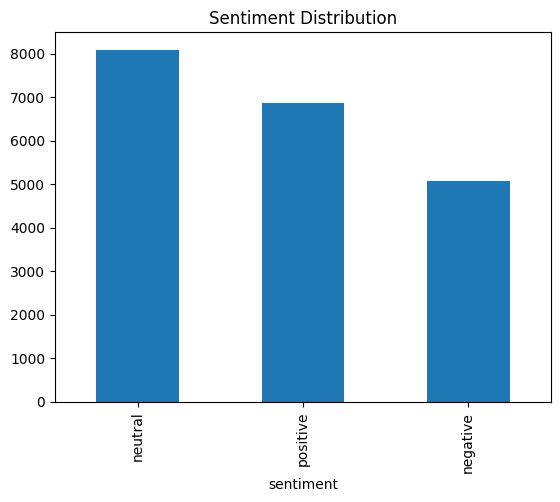

In [215]:
df['sentiment'].value_counts().plot(kind='bar')
plt.title("Sentiment Distribution")
plt.show()

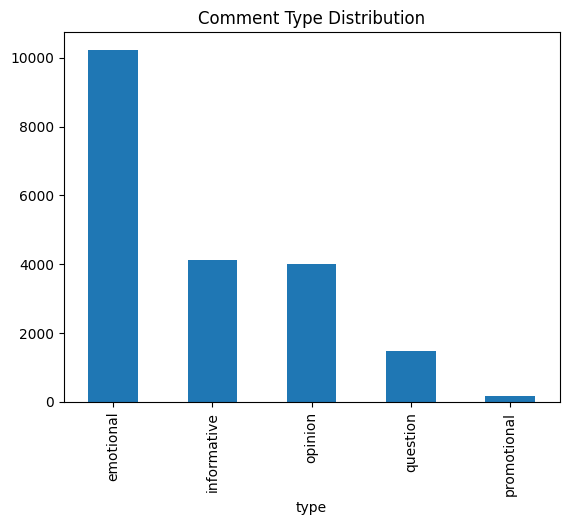

In [216]:
df['type'].value_counts().plot(kind='bar')
plt.title("Comment Type Distribution")
plt.show()

*****
## Preprocessing

In [217]:
mixed_stopwords = stopwords.words('english')
print(f"Number of English Stopwords: {len(mixed_stopwords)}")
print(f"Number of Bangla Stopwords: {len(bangla_stopwords)}")

mixed_stopwords.extend(bangla_stopwords)
print(f"Total Number of Mixed Stopwords: {len(mixed_stopwords)}")

Number of English Stopwords: 198
Number of Bangla Stopwords: 731
Total Number of Mixed Stopwords: 929


In [218]:
def remove_punctuation(text):
    punc = string.punctuation
    return text.translate(str.maketrans(' ', ' ', punc))

In [219]:
def remove_stopwords(text):
    new_text = []

    for word in text.lower().split():
        if word not in mixed_stopwords:
            new_text.append(word)
    
    return " ".join(new_text)

In [220]:
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

In [221]:
def remove_bangla_numbers(text):
    return re.sub(r'[১-০]', '', text)

In [222]:
def remove_special_characters(text):
    pattern = re.compile(r'[-#@;:,।.!—?<>/\\|`~$%^&*()_=+{}\[\]\']')
    return pattern.sub('', text)

In [223]:
df['clean_comment'] = df['comment'].apply(remove_punctuation)
df['clean_comment'] = df['clean_comment'].apply(remove_stopwords)
df['clean_comment'] = df['clean_comment'].apply(remove_numbers)
df['clean_comment'] = df['clean_comment'].apply(remove_special_characters)
df['clean_comment'] = df['clean_comment']

In [224]:
df.sample(10)

,comment,type,sentiment,clean_comment
14397,your big fan dada,emotional,positive,big fan dada
19149,it was really funny,opinion,positive,really funny
10619,তুই ওদের নিয়ে সামাচোলনা করলে ওদের কিসসু হবে না,opinion,negative,তুই সামাচোলনা কিসসু না
979,দ্বায়িত্ব,informative,neutral,দ্বায়িত্ব
15086,hayre.. gaana dot com,informative,neutral,hayre gaana dot com
7582,aloo khalo,informative,neutral,aloo khalo
5621,মনে চাই আবার বন্ধদের নিয়ে ফিরে যাই কোনো স্বাথ ...,emotional,positive,চাই বন্ধদের স্বাথ শৈশবে
5095,2019,informative,neutral,
6186,শৈশবের সেই দিন আর নেই।,emotional,negative,শৈশবের নেই
18029,hi prottoy heron iam your big fan,emotional,positive,hi prottoy heron iam big fan


In [225]:
# helper function to recognizee language
def is_bangla(text):
    for ch in text:
        if '\u0980' <= ch <= '\u09FF':
            return True
    return False

def is_english(text):
    for ch in text:
        if 'a' <= ch <= 'z' or 'A' <= ch <= 'Z':
            if not is_bangla(text):
                return True
    return False

In [226]:
# test the functions
sample = df['clean_comment'][random.randint(0, len(df)-1)]
print("Sample Text:",sample)
print("Is Bangla?:", is_bangla(sample))
print("Is English?:", is_english(sample))

Sample Text: ai anuvuti bole bojano impossible
Is Bangla?: False
Is English?: True


In [227]:
english_stemmer = PorterStemmer()
bangla_stemmer = BanglaStemmer()

def lematize_text(text):
    processed_text = []

    for word in text.split():
        if is_english(word):
            stemmed_word = english_stemmer.stem(word)
        elif is_bangla(word):
            stemmed_word = bangla_stemmer.stem(word)
        else:
            stemmed_word = word
        processed_text.append(stemmed_word)
    
    return " ".join(processed_text)

In [228]:
df['clean_comment'] = df['clean_comment'].apply(lematize_text)

df.sample(10)

,comment,type,sentiment,clean_comment
11273,17:09 dekhe mone porlo ma gas booked korte bol...,opinion,neutral,dekh mone porlo ga book kort bole chilo taratr...
1099,২৫ বছর বয়সেই জীবনের বড় ধাক্কা টা খেলাম,emotional,negative,বয়সে জীবন বড় ধাক্কা খেলাম
15937,সমাজ বিরোধি,emotional,negative,সমাজ বিরোধি
7541,ой моя любимая песенка,emotional,positive,ой моя любимая песенка
17027,sayeed ভাইয়ের ভিডিও গুলা অনেক ভালো লাগে...,opinion,positive,saye ভাইয় ভিডি গুলা ভালো লাগ
7143,rgggjhhjfjy,informative,neutral,rgggjhhjfji
18393,parley tawhid afridir moto video bana. haauar ...,informative,neutral,parley tawhid afridir moto video bana haauar pola
541,আমার জীবনের সাথে হুবহুব মিলিয়ে কি ভাবে আপনি এই...,emotional,positive,জীবন সাথ হুবহুব মিলি গান লিখ গান কথা অসাধারণ
1630,valo,emotional,positive,valo
14529,you are a best youtuber best best best youtube...,opinion,positive,best youtub best best best youtub bong guy


In [229]:
for index, row in df.iterrows():
    if str(row['clean_comment']).strip() == "":
        df.at[index, 'clean_comment'] = np.nan

df.isnull().sum()

comment            0
type               0
sentiment          0
clean_comment    525
dtype: int64

In [230]:
df.dropna(inplace=True)

In [231]:
df.isnull().sum()

comment          0
type             0
sentiment        0
clean_comment    0
dtype: int64

In [232]:
df.drop(columns=['comment'], inplace=True)

In [233]:
# final dataset info before encoding
print(f"Shape of the dataset: {df.shape}\n")
df.info()

Shape of the dataset: (19482, 3)

<class 'pandas.core.frame.DataFrame'>
Index: 19482 entries, 0 to 20006
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   type           19482 non-null  object
 1   sentiment      19482 non-null  object
 2   clean_comment  19482 non-null  object
dtypes: object(3)
memory usage: 608.8+ KB


In [234]:
df.head()

,type,sentiment,clean_comment
0,emotional,negative,গান শুন তখন শহর ছাড় ঘন্ বেঁজ গ মাসে বাসা ছেড়ে ...
1,emotional,positive,tnx gan ta onak sundorw hope amon sundor gan a...
2,emotional,negative,ei shohor amar noy
3,emotional,positive,এলাকা ছাড়া গান সুর নয়প্রতি লাইন একেক স্মৃতির আকাশ
4,informative,positive,স্মীতি গেলাম আপনা মাঝেযখন লাইক দি নোটিফিকেশন আ...


In [235]:
df['seq_len'] = df['clean_comment'].apply(lambda x: len(x.split()))

max_len = df['seq_len'].max()
min_len = df['seq_len'].min()
avg_len = df['seq_len'].mean()
median_len = df['seq_len'].median()

print(f"Maximum Sequence Length: {max_len}")
print(f"Minimum Sequence Length: {min_len}")
print(f"Average Sequence Length: {avg_len}")
print(f"Median Sequence Length: {median_len}")

Maximum Sequence Length: 476
Minimum Sequence Length: 1
Average Sequence Length: 6.729493891797556
Median Sequence Length: 4.0


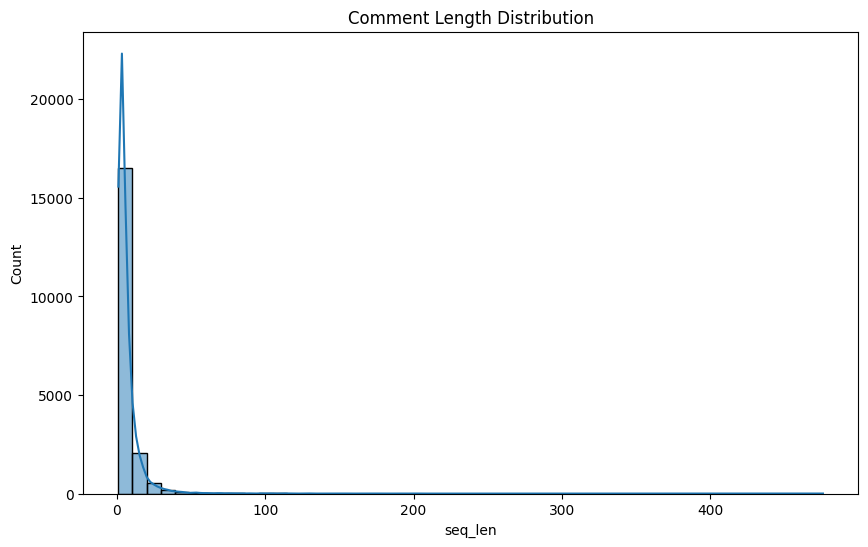

In [236]:
plt.figure(figsize=(10,6))
sns.histplot(df['seq_len'], bins=50, kde=True)
plt.title("Comment Length Distribution")
plt.show()

In [237]:
english_df = df[df['clean_comment'].apply(is_english)]
positive = english_df[english_df['sentiment'] == 'positive']
positive = " ".join(positive['clean_comment'].to_list()[:400])

negative = english_df[english_df['sentiment'] == 'negative']
negative = " ".join(negative['clean_comment'].to_list()[:400])

neutral = english_df[english_df['sentiment'] == 'neutral']
neutral = " ".join(neutral['clean_comment'].to_list()[:400])

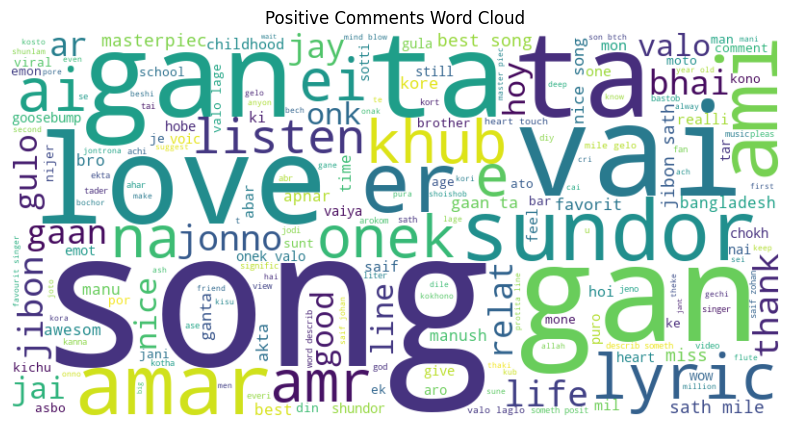

In [238]:
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
).generate(positive)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Comments Word Cloud")
plt.savefig('./figures/positive_wordcloud.png')
plt.show()

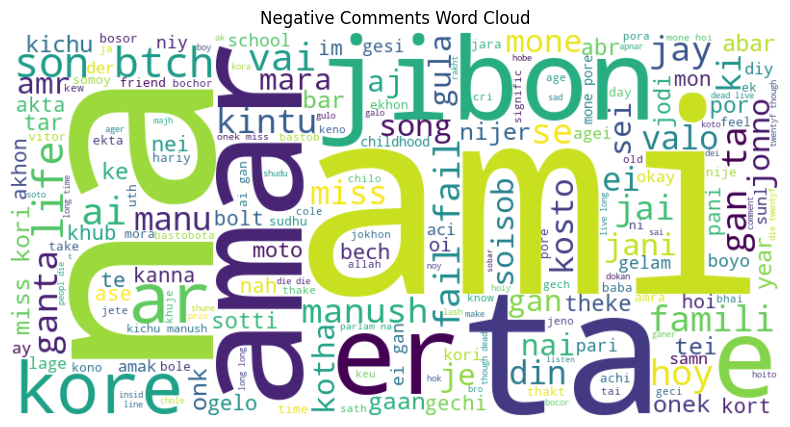

In [239]:
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
).generate(negative)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Comments Word Cloud")
plt.savefig('./figures/negative_wordcloud.png')
plt.show()

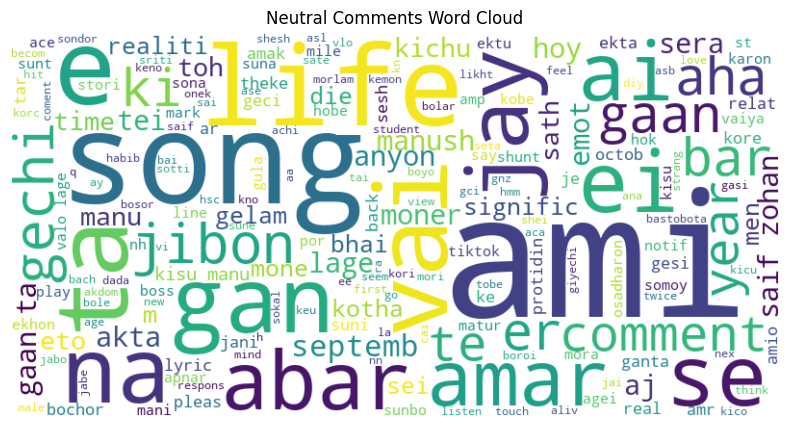

In [240]:
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
).generate(neutral)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Neutral Comments Word Cloud")
plt.savefig('./figures/neutral_wordcloud.png')
plt.show()

In [241]:
del positive, negative, neutral, english_df, wc

In [242]:
# save the cleaned dataset
df.to_csv("./data/clean_youtube_comment_dataset.csv", index=False)

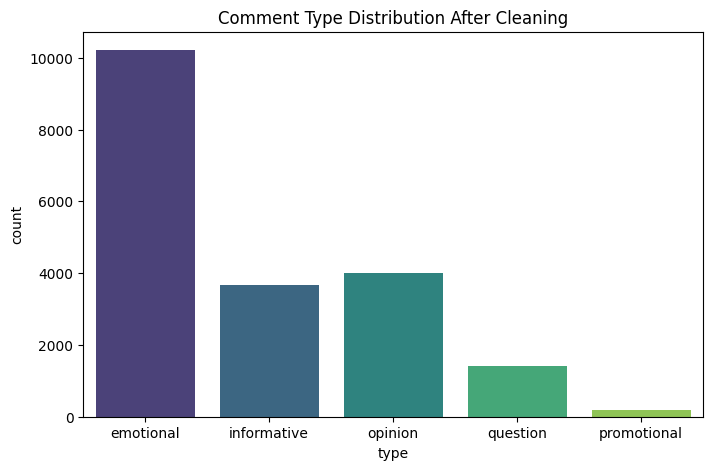

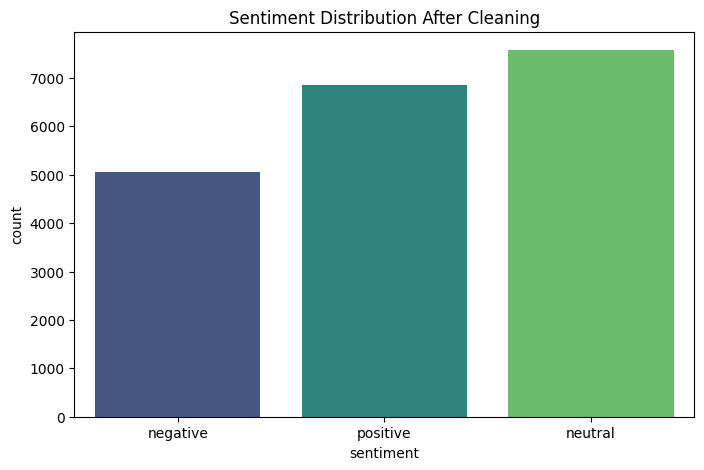

In [243]:
# comment type distribution after cleaning
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='type', palette='viridis')
plt.title("Comment Type Distribution After Cleaning")
plt.savefig('./figures/comment_type_distribution_after_cleaning.png')
plt.show()

# sentiment distribution after cleaning
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentiment', palette='viridis')
plt.title("Sentiment Distribution After Cleaning")
plt.savefig('./figures/sentiment_distribution_after_cleaning.png')
plt.show()

*****
*****
## Tokenization and Embedding Generation

In [244]:
df= shuffle(df).reset_index(drop=True)
df.head()

,type,sentiment,clean_comment,seq_len
0,opinion,positive,দারুন মাধ্যমিক রেজাল্ট,3
1,opinion,neutral,td dekhlei valo lage,4
2,emotional,positive,মিনিট বাচ্ছা গিয়েছিলাম,3
3,emotional,negative,সৈসব পেতাম,2
4,informative,neutral,গান ভিতর না পুরুষ জীবন কথা,6


In [245]:
# categorial label encoding
type_le = LabelEncoder()
sentiment_le = LabelEncoder()

df['type'] = type_le.fit_transform(df['type'])
df['sentiment'] = sentiment_le.fit_transform(df['sentiment'])

In [246]:
df.head()

,type,sentiment,clean_comment,seq_len
0,2,2,দারুন মাধ্যমিক রেজাল্ট,3
1,2,1,td dekhlei valo lage,4
2,0,2,মিনিট বাচ্ছা গিয়েছিলাম,3
3,0,0,সৈসব পেতাম,2
4,1,1,গান ভিতর না পুরুষ জীবন কথা,6


In [247]:
# save the label encoders
joblib.dump(type_le, './models/type_label_encoder.pkl')
joblib.dump(sentiment_le, './models/sentiment_label_encoder.pkl')

['./models/sentiment_label_encoder.pkl']

In [175]:
X = df['clean_comment']
y = df[['type', 'sentiment']]
X.shape, y.shape

((19482,), (19482, 2))

In [185]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=42
)

X_test, X_val, y_test, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42
)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((15585,), (15585, 2), (1949,), (1949, 2), (1948,), (1948, 2))

# Tokenizers: 
### For Traditional ML models - tfidf/ word2vec/ countvectorizer
### For DL models (pytorch) - nltk tokenizer with padding sequence length
### For Transformer Models - HuggingFace model specific tokenizer